# Исследование поиска перспективного игрового проекта

Интернет-магазине «Стримчик», занимается продажей компьютерных игр по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года (данные за 2016 год неполные). Представим, что сейчас декабрь 2016 г и мы планируем кампанию на 2017-й. Нам нужно отработать принцип работы с данными.

**Цели исследования:**
* за какой характерный срок появляются новые и исчезают старые платформы
* связь оценки пользователей и критиков на общие продажи
* жанры с высокими и низкими продажами, их отличия
* составить портрет пользователя каждого региона (NA, EU, JP)
* проверить гипотезы:
    - средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
    
**Ход исследования:** Изучить набор данных. Обработать данные если потребуется. Решить поставленные цели, по возможности используя визуальные инструменты. Принять или опровергнуть выдвинутые гипотезы. Составить общий вывод.

## Изучение данных

Импортируем библиотеки для работы с данными, которые нам понадобятся: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

Откроем файл с данными и посмотрим на первые 10 строчек таблицы:

На стадии визуального знакомства с таблицей, можно обратить внимание:
- на наличие пустых значений
- некорректная запись: целочисленные значения в формате float

Рассмотрим в целом информацию по таблице:



В колонке `Name` и `Genre` отсуствует два значения: такими пропусками можно будет в дальнейшем пренебречь. Для  `Year_of_Release` стоит поменять тип на целочисленный, a `User_Score` в дробный. Большая часть пропусков присуствуют в `Critic_Score`,`User_Score` и `Rating`.

### Вывод

Мы ознакомились с первыми данными таблицы. В целом большая часть колонок не имеют пропусков. Не значительное количество пропущенных значений можно просто удалить из таблицы, не опасаясь их влияния на исследования. Пропуски которые присутсвуют в оценках пользователей и критиков имеют весомые значения для исследования. Такие пропуски не стоит удалять. Возможно их появление связанно с малой популярностью продукта, региональными ограничемиями или неправильной выгрузкой данных.

## Обработка данных

Приступим к изменению названия столбцом, а именно переписать их в нижний регистр

In [4]:
data.columns = data.columns.str.lower()

В колонке `name` присуствуют два пропуска

In [5]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Два пропуска в `genre` также  связнные с этими строчками, т.к они не повлияют на наше исследование,смело удалим их нашего датасета:

In [6]:
data.dropna(subset=['name'], inplace=True)

Перед тем как изменить тип данных для `year_of_release`, нам потребуется повлиять на пропуски. Интересный момент: пропуски имеются у игр которые выходили на несколько платформ. 

In [7]:
data.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Данные пробел мы можем восполнить датами игр на других платформ:

In [8]:
for name in data[data['year_of_release'].isna()]['name'].unique(): #создаём цикл по уникальным именам среди игр с пропусками в дате
    year = data.loc[data['name'] == name, 'year_of_release'].max()
    data.loc[(data['year_of_release'].isna()) & (data['name'] == name), 'year_of_release'] = year 

Посмотрим долю оставшихся, незаполненых игр: 

In [9]:
print('Доля пропусков от общего числа данных:',(data['year_of_release'].isna().sum() / len(data) ).round(3))

Доля пропусков от общего числа данных: 0.009


Так как доля пропусков не большая и год является категоральной величиной,что означает замена медианой или средним будет некорректно. Мы удалим пропуски, а затем поменяем тип данных на `int`.

In [10]:
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int')

`critic_score` и `user_score` являются важными для исследования данными. Так как количество отсуствующих значений по датасету выше по сравнению с остальными, удалять их ни в коем случаи нельзя. Данные мы пока что оставляем без изменений. 

В колонке `user_score` присуствует значение tbd (сокр.анг. *to be defined - "подлежащий определению"*). Значение tbd пишут на месте недостающей информации, планируя позже заменить на реальные данные, когда те станут известны. Так как данные у нас отсуствуют, заменим tbd значения на `nan`. 

Также колонку стоит перевести из типа `object` в дробный `float`.

In [11]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data['user_score'] = data['user_score'].astype('float')

Столбец `rating` является категоральной величиной, поэтому пропуски мы не можем заменять медианой или средним. Возрастной рейтинг является важной метрикой для нашего анализа. Количество пропусков может повлиять на общих исход. В начале посмотрим на долю такие пропусков от "общей массы":

In [12]:
print('Доля пропусков от общего числа данных:',(data['rating'].isna().sum() / len(data) ).round(3))

Доля пропусков от общего числа данных: 0.404


Такая доля пропущенных значений может повлиять на наш анализ, так как значения категоральные, заменим значением заглушкой`INDF` ("Indefinite" - *неопрделенно*): 

In [13]:
data['rating'] = data['rating'].fillna('INDF')

В дальнейшем для исследования нам понадобятся суммарная выручка игры по всему миру. Для этого просуммируем выручки с каждого региона и вынесем отдельной колонкой в таблице:

In [14]:
data['sum_sales'] = data.loc[:, 'na_sales':'other_sales'].sum(axis=1)

Посмотрим на итоговый результат:

### Вывод

Мы ознакомились с предоставленными данными. Несущественные пропуски в значениях мы убрали из датасета. Данные с оценкой пользователей и критиков оставили без изменений, так как любое значение может повлиять на результаты корреляционого анализа. 


## Исследовательский анализ данных 

Рассмотрим сколько игр выходило в период с 1980 по 2016 год:

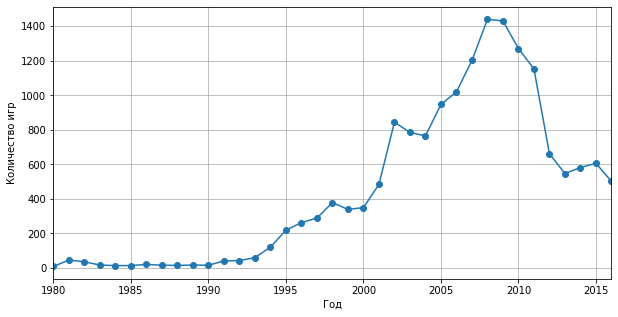

In [16]:
(data
 .groupby('year_of_release')['name']
 .count()
 .plot(grid=True, style='o-', figsize=(10,5))
)
plt.xlim(1980,2016)
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

На графике можно увидеть:

* самое высокое количество проданных игр приходится на 2008 и 2009 год
* рост продаж начинается с 1994 года
* с 2010 года наблюдается падание продаж до 2012. Мы можем предположить что это связанно с бурным появлением торрентов и пиратского распространнеия игр. Так как не все платформы позволяют использовать не лицензионный контент.

Период до 1994 года, дальше мы рассматривать не будем.


Посмотрим топ-5 платформ с самыми высокими продажами игр на них:

In [17]:
(data.groupby('platform')['sum_sales']
 .sum()
 .sort_values(ascending=False)
 .head()
)

platform
PS2     1247.16
X360     966.61
PS3      935.19
Wii      903.31
DS       804.28
Name: sum_sales, dtype: float64

По данному топу построим график и ответим на вопрос: "За какой характерный срок появляются новые и исчезают старые платформы?"

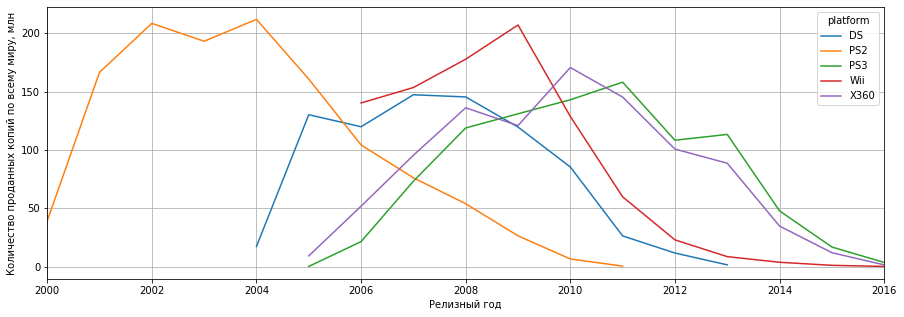

In [18]:
(
    data.query('platform == ["PS2","X360","PS3","Wii","DS"] and year_of_release >= 1994' )
.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(figsize=(15,5),grid=True)

)
plt.xlabel('Релизный год')
plt.ylabel("Количество проданных копий по всему миру, млн")
plt.show()

Мы можем увидеть что продажи для платформы в среднем держатся 10 лет. При этом пик приходится примерно на середину, через 5 лет после старта продаж. 

Т.к мы планируем анализ для кампании 2017 года, то будет правильным решение анализировать данные за последние 5 лет, то есть с 2012 года. Тем самым в наш анализ будут входить потенциально прибыльные платформы.

In [19]:
actual_data = data.query('year_of_release >= 2012')

Рассмотрим самые прибыльние платформы для нашего анализа по актуальным данным:

In [20]:
(
    actual_data.groupby('platform')['sum_sales']
    .sum()
    .sort_values(ascending=False)
)

platform
PS4     314.14
PS3     289.71
X360    237.52
3DS     195.01
XOne    159.32
WiiU     82.19
PC       63.51
PSV      49.18
Wii      36.60
DS       13.21
PSP      11.69
Name: sum_sales, dtype: float64

По этим данным сложно опредить какая платформа падает, а какая только набирает обороты. Построим график:

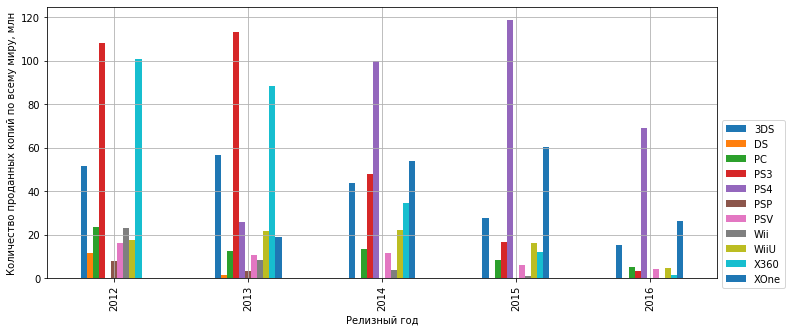

In [21]:
(
    actual_data
    .pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(kind='bar',figsize=(12,5),grid=True, label=True)

)
plt.legend(bbox_to_anchor=(1, 0.6))
plt.xlabel('Релизный год')
plt.ylabel("Количество проданных копий по всему миру, млн")
plt.show()

Падание графиков на 2016 году связанно с неполными данными для этого года. 

Мы можем увидеть что в целом выделяется рост трёх платформ: PS4, XOne и 3DS.

Также стоит упомянуть про PC. Продажи для данной платформы не высоки, но стабильны во времени. Что связанно с возможностью постоянной заменой комплектующих.

Построим диаграмму размаха для наших платформ по продажам:

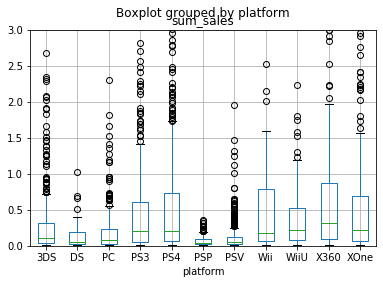

In [23]:
actual_data.boxplot(column = 'sum_sales', by = 'platform')
plt.ylim(0,3)
plt.show()

По диаграмме можно увидеть что медиана, примерно на одном уровне для платформ с высокими продажами. Следовательно продажи держатся на одной позиции. Также можно обратить внимание на скошеность вверх для большинства платформ, что говорит об их прогрессивности развития, а следовательно к увеличению продаж. Графиком выше мы уже определили какие платформы сейчас у нас "на подъёме".

Стоит также упомянуть про выбросы (круглые точки), которые мы можем увидеть: выходит множество проектов на платформу, и в зависимости от качества, маркетинга и многих других факторов, проект приносит различную прибыль. Поэтому стоит не игнорировать такие точки на графике, а держать в голове как показатель успешности проекта на платформе.

Рассмотрим влияние продаж популярной платформы ( в нашем примере будет PS4) от пользователей и критиков. Рассмотрим для начала график:

In [24]:
ps4 = actual_data[actual_data['platform'] == 'PS4'] # используем датасет только с данными по платформе PS4

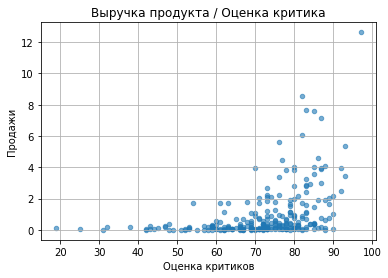

In [25]:
ps4.plot(kind='scatter',
                x='critic_score',
                y='sum_sales',
                 grid=True,
                 alpha = 0.6,
                title = 'Выручка продукта / Оценка критика')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.show()

Можно обратить внимание, что с оценкой выше 50 количество продаж начинается расти, но не существенно. Можно увидеть не высокую, но линейную связь, между этими показателями.  

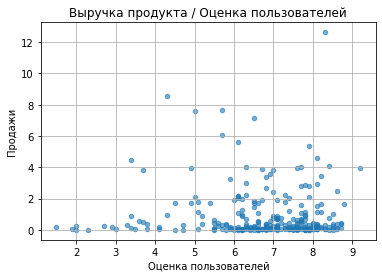

In [26]:
ps4.plot(kind='scatter',
                x='user_score',
                y='sum_sales',
                 grid=True,
                 alpha = 0.6,
                title = 'Выручка продукта / Оценка пользователей')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.show()

На графике можно увидеть, что продажи чаще совершаются у продуктов с оценкой от игроков выше 5.5, но суммарно количество продаж от этого не увеличивается, возможно взаимосвязь двух параметров намного сложнее.

Посмотрим на числовые значения корреляции: 

In [27]:
ps4[['sum_sales','critic_score','user_score']].corr()

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


Также как и по графику, можем увидеть линейную связь оценки критиков и общих продаж. Для пользотелей, знак не имеет значение, так как связь практически равна 0. 

Посмотрим корреляцию для XOne и PC:

In [28]:
display('Корреляция для XOne',
      actual_data[actual_data['platform'] == 'XOne'][['sum_sales','critic_score','user_score']].corr()
     )
display('Корреляция для PC',
      actual_data[actual_data['platform'] == 'PC'][['sum_sales','critic_score','user_score']].corr()
     )

'Корреляция для XOne'

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


'Корреляция для PC'

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.240570,-0.120339
critic_score,0.240570,1.000000,0.431879
user_score,-0.120339,0.431879,1.000000


Корреляции для разных платформ немного различаются, но в целом примерно в равном диапозоне. Следовательно вывод для остальных платформ схож с корреляцией для PS4.

Рассмотрим жанры с высокими/низкими продажами:

In [29]:
games = (actual_data
 .pivot_table(index='genre', values = 'sum_sales', aggfunc=['sum','count'])
)
games.columns = ['Выручка','Количество игр']
games['Средняя выручка за 1 игру'] = games['Выручка'] / games['Количество игр']
games.sort_values('Выручка', ascending=False)

,Выручка,Количество игр,Средняя выручка за 1 игру
genre,,,
Action,446.41,1041,0.428828
Shooter,304.75,237,1.285865
Role-Playing,192.80,370,0.521081
Sports,181.07,268,0.675634
Misc,85.28,193,0.441865
Platform,61.00,85,0.717647
Racing,53.50,115,0.465217
Fighting,44.49,109,0.408165
Simulation,35.12,80,0.439000


На первых местах находятся игры жанра Action, Shooter. Низкие продажи имеют игры с плавными геймплеем: Puzzle,Strategy. Также специально в таблицу добавленны количество игр. Можно увидеть что Adventure имеют большое количество игр, но при этом жанр особо не приносит доход. Тем самым можно судить о востреботельности жанра на рынке.

### Вывод

Основной подъём продаж игр начинается с 1994 года. До появление безлимитного интернета и торрентов объёмы продаж увеличивались до 2008-2009 года, где потом незначительно упали. За всё это время больше всего прибыли принесла платформа PS2 и продержалась около 10 лет на рынке. В среднем это и является примерным возрастом актуальности для большинства платформ. 

Построев диаграмму размаха мы определили, что продажи зависят только от оценки критиков, что вполне логично. Пользователи доверяют мнению профессионалов. 

Мы узнали, что для пользователей на первых местах жанры с активными действиями на экране. Хотя они и приносят в общем большую выручку, зачастую не каждая игра в этом жанре в среднем хорошо продаётся.

## Портрет пользователя 
Составим портрет пользователя для каждого из трёх регионов (NA, EU, JP). Нам понадобится:
* составить топ-5 платформ
* составить топ-5 жанров
* влияние возрастного рейтинга ESRB на продажи


Рассмотри графически топ-5 платформ по круговой диаграмме. Пренебрежим не вошедшими платформами и будем считать, что топ-5 состовляет 100% всего рынка продаж.

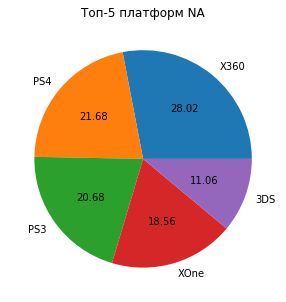

In [30]:
(
    actual_data.groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 платформ NA',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Топ делят между собой примерно в равных количествах платформы корпорации "Microsoft" XOne, X360 и "Playstation" PS4 и PS3. Компания "Microsoft" является американской компанией, имеет большое распостренение в NA. Но так как платформы "Playstation", являются популярны на мировым рынке, внесли свою долю продаж для рынка NA. 

Рассмотрим топ-5 жанров NA:

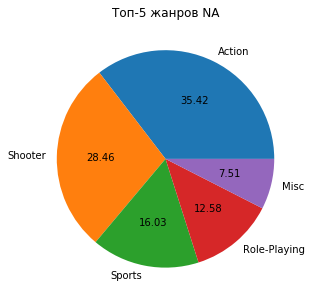

In [31]:
(
    actual_data.groupby('genre')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 жанров NA',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Основные жанры в NA являются, аналогичные для международного рынка. Такая схожесть возможна из-за доли рынка NA к мировой. 

In [32]:
print('Доля рынка NA от мирового: {:.1%}'.format(actual_data['na_sales'].sum()/actual_data['sum_sales'].sum()))

Доля рынка NA от мирового: 40.9%


Следовательно жанры мирового рынка и NA имеют сходство. 

Рассмотрим влияние рейтинга ESRB на продажи:

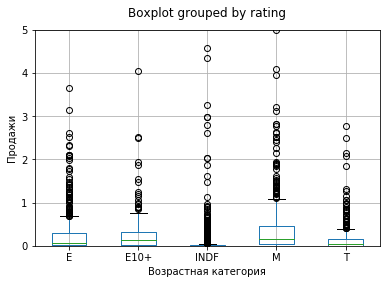

In [33]:
actual_data.boxplot(column = 'na_sales', by = 'rating')
plt.ylim(0,5)
plt.title(None)
plt.xlabel("Возрастная категория")
plt.ylabel('Продажи')
plt.show()

Медианные значения немного отличаются друг от друга, хоть и не существенно. Стоит выделить, значения для рейтинга **М** - дети не младше 17, скорее всего это связана с популярностью игр жанра Action.

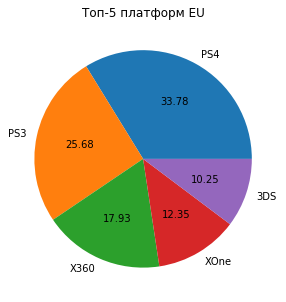

In [34]:
(
    actual_data.groupby('platform')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 платформ EU',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Основные платформы для EU являются семейство Playstation. Продажи платформ корпорации "Microsoft" суммарно меньше продаж PS4.  Посмотрим на сколько распространнена платформа на EU рынка от мирового:

In [35]:
print('Доля платформ PS4 для EU от мира: {:.1%}'
      .format(actual_data[actual_data['platform'] == 'PS4']['eu_sales'].sum() 
              / actual_data[actual_data['platform'] == 'PS4']['sum_sales'].sum())
     )


Доля платформ PS4 для EU от мира: 44.9%


Рассмотри топ-5 жанров EU:

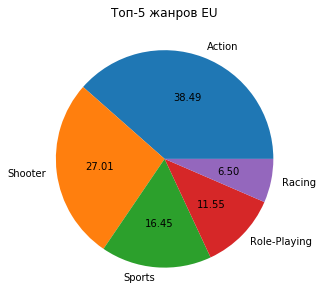

In [36]:
(
    actual_data.groupby('genre')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 жанров EU',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Аналогино топу NA, Европейские не сильно отличается по долям. Отличия имеются только в последнем месте. Для EU характера любовь к гонкам и машина, следовательно рейтингу Racing. Посмотрим чем обоснованно такая схожесть с NA и мировым топом:

In [37]:
print('Доля рынка EU от мирового: {:.1%}'.format(actual_data['eu_sales'].sum()/actual_data['sum_sales'].sum()))

Доля рынка EU от мирового: 35.1%


Столь высокая схожесть обусловлена, такой же высокой долей продаж как и для NA от мира.

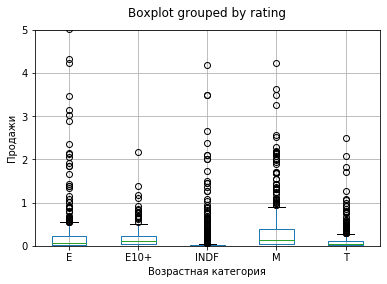

In [38]:
actual_data.boxplot(column = 'eu_sales', by = 'rating')
plt.ylim(0,5)
plt.title(None)
plt.xlabel("Возрастная категория")
plt.ylabel('Продажи')
plt.show()

Ситуация для EU аналогична NA: медианные значения немного отличаются друг от друга, хоть и не существенно.

Рассмотри топ-5 платформ для JP:

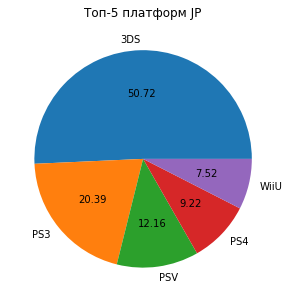

In [39]:
(
    actual_data.groupby('platform')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 платформ JP',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Рынок JP отличается своей спецификой от мирового. Предпочтение отдаются портативным платформам (WiiU, 3DS, PSV) и продуктами японской компаний "Nintendo" и японско-американской "Playstation".

Рассмотрим топ-5 жанров JP:

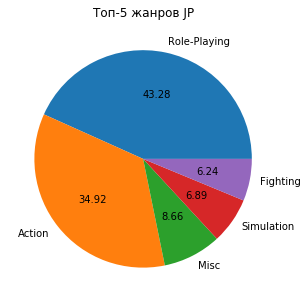

In [40]:
(
    actual_data.groupby('genre')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie',autopct='%.2f',title='Топ-5 жанров JP',figsize=(5,5))    
)
plt.ylabel(None)
plt.show()

Жанр Action для JP рынка занимает второе место, в отличии от мирового и устпает Role-Playing. Возможно такое отличие связано с платформами, на которых игры данного жанра больше популярны и распостранены для данного рынка. Посмотрим на топ платформ для жанра Role-Playing:

In [41]:
(
    actual_data.query('genre == "Role-Playing"')
    .groupby('platform')['jp_sales']
    .sum()
    .sort_values(ascending = False)
    .head()
)

platform
3DS    38.93
PSV     7.68
PS3     6.86
PS4     3.55
DS      3.51
Name: jp_sales, dtype: float64

4 из 5 платформ являются самыми распространнёными  для рынка JP. Тем самым мы можем понять чем вызван интерес к играм жанра Role-Playing.

Рассмотрим теперь связь возрастного рейтинга и продаж:

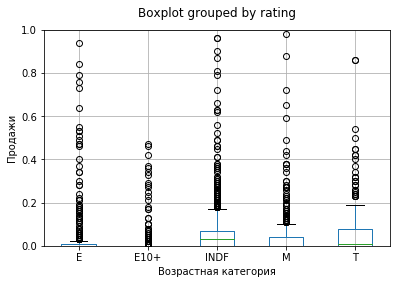

In [42]:
actual_data.boxplot(column = 'jp_sales', by = 'rating')
plt.ylim(0,1)
plt.title(None)
plt.xlabel("Возрастная категория")
plt.ylabel('Продажи')
plt.show()

Медианные значения имеют маленькие значения.Стоит обратить внимание на преобладание категории **T** для детей от 13 лет. Также высокое значения **INDF** - игр для которых возрастной рейтинг отсуствовал. По количеству выбросов можно сказать что продаж таких игр высокий. Это затрудняет определение связи продаж от возрастного рейтинга в регионе. 

### Вывод

Основную долю мирового рынка составляет EU и NA. Что сказывается на общих чертах в выборе жанра. JP рынок имеет отличие в жанре, связанные с выбором платформы и продуктов доступных на нём. Для платформ, все три региона в разных долях предпочитают PS4 и PS3. Причём для NA характера преобладание платформ американских кампаний, для JP японских кампаний, а EU предпочитает японско-американский платформы. 

Возрастной рейтинг не сильно зависит для NA и EU, есть преобладающий рейтинг, но разница является не высокой. Для JP преобладает высокое количество игр с отсуствующим рейтингом. Для данного региона проблематично выяснить зависимость. 

## Проверка гипотез

В нашем исследовании расмотрим две гипотезы:
* средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* средние пользовательские рейтинги жанров Action и Sports разные

Приступик с первой гипотезы. Нулевой гипотезой для нас будет: *средние пользовательские рейтинги платформ Xbox One и PC равны между собой*, а значит альтернативной гипотезой будет: *средние пользовательские рейтинги платформ Xbox One и PC не равны между собой*. 

Для того чтобы отвергнуть или наоборот принять гипотезу, у нас имеется две генеральных совокупности. Мы можем сравнить их среднее с применением библиотеки `scipy` и её методов, через критерий Стьюдента. Для большей точности, мы возьмём уровень значимости равный 1%.

Так как в оценках пользователя имеются пропуски, мы не сможем провести тест. Удалим их, так как другие значения могут повлиять на результат проверки гипотезы.

In [43]:
filter_data = actual_data.dropna(subset=['user_score']) 

xone_score = filter_data[filter_data['platform'] == 'XOne']['user_score']
pc_score = filter_data[filter_data['platform'] == 'PC']['user_score']
alpha = 0.01 # уровень значимости

result = st.ttest_ind(xone_score, pc_score)

print('p - значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p - значение: 0.6252774522173157
Не отвергаем нулевую гипотезу


По результатам теста мы можем сказать что в среднем оценки пользователей PC и XOne равны между собой. Это говорит нам о том, что продукты выпускаемые на эти две платформы, в среднем одинаково оцениваются. Стоит добавить из личного опыта, что многие проекты для консолей XOne также играются на PC. Один и тот же проект, одинаково себя показывает на двух платформах. 
средние пользовательские рейтинги жанров Action и Sports разные
Рассмотрим вторую гипотезу и также составим нулевую и альтернативную:
* нулевой гипотезой у нас будет: *средние пользовательские рейтинги жанров Action и Sports равны между собой*
* альтернативная гипотеза: *ссредние пользовательские рейтинги жанров Action и Sports отличаются между собой*

Также чтобы принять или отвергнуть гипотезу, мы сравним среднии двух генеральных совокупностей: оценки жанра Action и Sports между собой, через критерий Стьюдента и возьмём уровень значимости 1%.

In [44]:
action_score = filter_data[filter_data['genre'] == 'Action']['user_score']
sports_score = filter_data[filter_data['genre'] == 'Sports']['user_score']
alpha = 0.01 # уровень значимости

result = st.ttest_ind(action_score, sports_score)

print('p - значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p - значение: 1.1405639632267916e-26
Отвергаем нулевую гипотезу


На основе полученных данных, мы отвергаем нулевую гипотезу, а следовательно можем сказать что средние пользовательские рейтинги жанров Action и Sport не равны между собой.

### Вывод 

Благодаря полученным результатам статистических тестов мы можем сказать, что наши гипотезы частично подвердились: пользоватейский рейтинг для XOne и PC между собой равны. Мы можем сделать вывод, что проекты выпускаемые на обе платформы будут одинаково оценены между собой. 

Пользовательские оценки для жанров Action и Sports отличаются. Стоит вспомнить что ранее смотрели популярность каждого жанра и количество игр. Action ощутимо выигрывает: пользователи чаще оценивают и выбирают игры данного жанра.

## Общий вывод

Ознакомившись с данными и построив графики, мы обнаружили: 
* среднем для самых успешных платформ "время жизни" составляет примерно 10 лет. Наиболее перспективно выбирать платформы, которые находятся на пике продаж (половина от времени жизни - 5 лет).
* если игра будет хорошо оценена критиками, это увеличит продажи.
* наиболее популярными в мире жанрами являются игры с высокой динамичностью (такие как Action, Shooter).
* для рынка NA стоит выбирать консоли XOne и PS4, хоть и лидирует X360, первые две плаформы имеют перспективу роста в дальнейшем, но большим плюсом будет и поддержка консолей прошлого поколения. Предпочтение отдаётся жанрам: Action,Shooter,Sports
* для рынка EU ситуация аналогично с NA, но больший спрос будут иметь платформы Playstation: PS4/PS3. Жанры аналогичны NA.
* для рынка JP стоит уделить внимание портативным платформам 3DS, PSV. Популярным жанром для рынка является: Role-Playing, Action
* стоит не уберать со счетов PC, хоть и платформа не входит в топ-5 платформ, будет всегда актуальна для любого года. 

Из полученого анализа мы можем предположить для успеха кампании в 2017 году по всему миру, стоит выбирать игры платформы PS4, жанра Action. Дополниельным плюсом будет, если игры выйдут также на XOne, прошлое поколение PS3 и X360 и будет иметь аналоги для портативных платформ 3DS и PSV.